In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randrange

%matplotlib inline

In [26]:
x = np.arange(10)

In [29]:
randrange(1000)

66

In [2]:
from sklearn.model_selection import train_test_split
from subprocess import check_output
print(check_output(["ls", "data/processed"]).decode("utf8"))

sample_submission.csv
test.json
train.json



In [61]:
np.random.seed(666)

In [60]:
print("load data...")
train = pd.read_json("data/processed/train.json")
test = pd.read_json("data/processed/test.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

load data...
done!


In [62]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)
#y_train = np.array(train["is_iceberg"])

In [7]:
train["band_1"].shape,train["band_2"].shape

((1604,), (1604,))

In [31]:
test["band_1"].shape,test["band_2"].shape

((8424,), (8424,))

In [10]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [32]:
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


top image of band_1


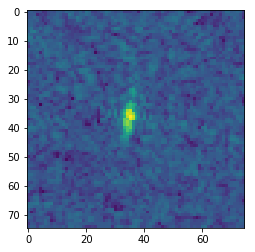

In [18]:
print("top image of band_1")
im = np.array(train.loc[0,"band_1"]).reshape([75,75])
plt.imshow(im)

top image of band_2


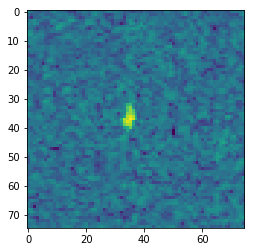

In [19]:
print("top image of band_2")
im = np.array(train.loc[0,"band_2"]).reshape([75,75])
plt.imshow(im)

In [22]:
x_band1.shape, x_band2.shape

((1604, 75, 75), (1604, 75, 75))

In [63]:
X_train.shape

(1604, 75, 75, 3)

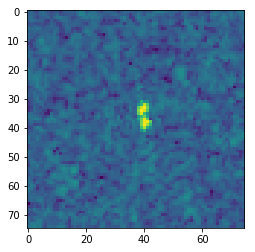

In [35]:
plt.imshow(X_test[0,:,:,2])

In [36]:
X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train
                    , X_angle_train, y_train, random_state=123, train_size=0.75)

In [37]:
print(X_train.shape, X_valid.shape, X_angle_train.shape, X_angle_valid.shape, y_train.shape, y_valid.shape) 
# 75% train / 25% validation .....

((1203, 75, 75, 3), (401, 75, 75, 3), (1203,), (401,), (1203,), (401,))


In [55]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping



#Import Keras.


In [39]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [40]:
def get_model():
    bn_model = 0
    p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    
    img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    img_concat =  (Concatenate()([img_1, img_2, BatchNormalization(momentum=bn_model)(input_2)]))
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

model = get_model()

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 75, 75, 3)     12          X_1[0][0]                        
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 73, 73, 16)    448         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 71, 71, 16)    2320        conv2d_1[0][0]                   
___________________________________________________________________________________________

# training parameters ... #

In [2]:
batch_size = 64
epochs = 5 ## change this to 80
steps_per_epoch=2^9/batch_size ## change to 2^14

In [45]:
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

model = get_model()
model.fit([X_train, X_angle_train], y_train, epochs=25
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 1203 samples, validate on 401 samples
Epoch 1/25
1203/1203 [==============================] - 57s - loss: 0.6855 - acc: 0.7016 - val_loss: 0.7186 - val_acc: 0.7182
Epoch 2/25
1203/1203 [==============================] - 55s - loss: 0.5229 - acc: 0.7814 - val_loss: 0.4330 - val_acc: 0.8005
Epoch 3/25
1203/1203 [==============================] - 51s - loss: 0.4745 - acc: 0.8047 - val_loss: 0.4485 - val_acc: 0.7980
Epoch 4/25
1203/1203 [==============================] - 51s - loss: 0.3886 - acc: 0.8263 - val_loss: 0.4648 - val_acc: 0.8354
Epoch 5/25
1203/1203 [==============================] - 51s - loss: 0.3665 - acc: 0.8454 - val_loss: 0.4030 - val_acc: 0.8304
Epoch 6/25
1203/1203 [==============================] - 51s - loss: 0.3283 - acc: 0.8736 - val_loss: 0.4245 - val_acc: 0.8653
Epoch 7/25
1203/1203 [==============================] - 51s - loss: 0.3070 - acc: 0.8712 - val_loss: 0.4276 - val_acc: 0.8454
Epoch 8/25
1203/1203 [==============================] - 51s - loss: 0.2

In [46]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))


Train evaluate:
1203/1203 [==============================] - 18s    
[0.15858378143344734, 0.93682460594652894]
####################
watch list evaluate:
400/401 [============================>.] - ETA: 0s[0.29131172454574533, 0.90773067212758818]


In [47]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8424/8424 [==============================] - 96s    


In [48]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

In [49]:
submission.head()

,id,is_iceberg
0,5941774d,0.028475
1,4023181e,0.036294
2,b20200e4,0.000005
3,e7f018bb,0.995570
4,4371c8c3,0.563699


In [51]:
submission.to_csv("/Users/donchan/Documents/Statistical_Mechanics/tensorflow/Iceberg/output/sub_keras_basic.csv",index=False)


# Another version #


In [54]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(x_band1[12,:,:], 'iceberg')

In [56]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(128))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


In [57]:
model = getModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 128)       73856     
__________

In [58]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights_1.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [64]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=16, train_size=0.75)

In [65]:
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 128)       73856     
__________

In [66]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - 1s     
('Test loss:', 0.28494011928464408)
('Test accuracy:', 0.86783042423742962)


In [67]:
predicted_test=gmodel.predict_proba(X_test)

8416/8424 [============================>.] - ETA: 0s

In [68]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv("/Users/donchan/Documents/Statistical_Mechanics/tensorflow/Iceberg/output/sub_keras_basic_1.csv", index=False)